# Titanic poly svc

In [27]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score, cross_val_predict ,GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score

sns.set()

# This checks if the notebook is executed on Kaggle or on your local machine and
# acts accordingly with filenames.
fname_train = "train.csv"
fname_test = "test.csv"

try:
    os.environ['KAGGLE_DATA_PROXY_TOKEN']
except KeyError:
    pass
else:
    dirname = "/kaggle/input/titanic/"
    fname_train = dirname + fname_train
    fname_test = dirname + fname_test

In [28]:
titanic = pd.read_csv(fname_train)
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

# Pretend we already know for sure that these are unimportant:
unnecessary = ["PassengerId", "Name","SibSp","Parch","Ticket", "Cabin", "Embarked"]
#unnecessary = ["PassengerId", "Name","Ticket", "Embarked"]
unnecessary = ["PassengerId", "Name","Ticket", "Embarked", "Cabin"]

titanic.drop(unnecessary, inplace=True, axis=1)
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.000000,1,0,7.2500
1,1,1,female,38.000000,1,0,71.2833
2,1,3,female,26.000000,0,0,7.9250
3,1,1,female,35.000000,1,0,53.1000
4,0,3,male,35.000000,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000
887,1,1,female,19.000000,0,0,30.0000
888,0,3,female,29.699118,1,2,23.4500
889,1,1,male,26.000000,0,0,30.0000


In [29]:
class CabinLetterOnly(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        df = pd.DataFrame(X, index=titanic.index, columns=titanic.columns)
        s_cabin_letters = df.Cabin.str.extract("^([A-Z]).*", expand = False)
        return np.c_[df.to_numpy(), s_cabin_letters]

sex_pip = Pipeline([
    ('one_hot', OneHotEncoder(categories=[titanic.Sex]))
])

fare_pip = Pipeline([
    ("fare_mean", SimpleImputer(strategy="mean")),
    ('fare_std', StandardScaler())
])

pclass_pip = Pipeline([
    ('pclass_std', StandardScaler())
])

age_pip = Pipeline([
    ('age_std', StandardScaler())
])

parch_pip = Pipeline([
    ('parch_std', StandardScaler())
])

sibsp_pip = Pipeline([
    ('sibsp_std', StandardScaler())
])

add_attrs = Pipeline([
    ("cabin_fill", SimpleImputer(strategy="most_frequent")),
    ("add_cabin_letters", CabinLetterOnly())
])

# new = add_attrs.fit_transform(titanic.values)
# titanic = pd.DataFrame(new, index=titanic.index, columns=titanic.columns.union(pd.Index(["Cabin_letter"]), sort=False))
# titanic.drop(["Cabin"], axis=1, inplace=True)

# cabin_pip = Pipeline([
#     ('cabin_1hot', OneHotEncoder(categories=[titanic.Cabin_letter]))
# ])

attr_pip = ColumnTransformer([
    #("passthrough", "passthrough", ["Pclass"]),
    ("pclass", pclass_pip, ["Pclass"]),
    ("sex", sex_pip, ["Sex"]),
    ("fare", fare_pip, ["Fare"]),
    ("age", fare_pip, ["Age"]),
    ("parch", parch_pip, ["Parch"]),
    ("sibsp", sibsp_pip, ["SibSp"]),
    #("cabin_add", add_attrs, ["Cabin"]),
    #("cabin_trans", cabin_pip, ["Cabin_letter"]),
], remainder="drop")

In [30]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_ix, test_ix in split.split(titanic, titanic["Sex"]):
    strat_train = titanic.loc[train_ix]
    strat_devtest = titanic.loc[test_ix]

In [31]:
titanic_labels = titanic["Survived"].astype(int)
strat_train_labels = strat_train["Survived"].astype(int)
strat_devtest_labels = strat_devtest["Survived"].astype(int)
strat_train.drop("Survived", inplace=True, axis=1)
strat_devtest.drop("Survived", inplace=True, axis=1)

In [32]:
strat_train_prep = attr_pip.fit_transform(strat_train)
strat_devtest_prep = attr_pip.fit_transform(strat_devtest)
skfold = StratifiedKFold(n_splits=5)

In [33]:
svc = SVC(random_state=42, probability=True)

In [34]:
param_grid = [
    {"random_state" : [42], "C" : [4], "kernel" : ["poly"], "degree" : [1],
    "coef0" : [2]}
]

gridsearch = GridSearchCV(svc, param_grid = param_grid, cv = skfold, scoring="accuracy", return_train_score=False)
gridsearch.fit(strat_train_prep, strat_train_labels)
best_svc = gridsearch.best_estimator_

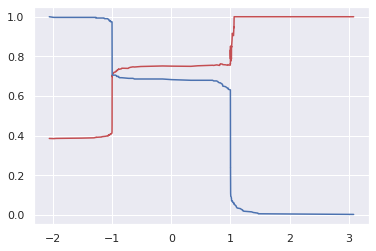

In [35]:
pred_scores = cross_val_predict(best_svc, strat_train_prep, strat_train_labels, cv = skfold, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(strat_train_labels, pred_scores)

sns.lineplot(thresholds, precisions[:-1], color="r")
sns.lineplot(thresholds, recalls[:-1], color="b")

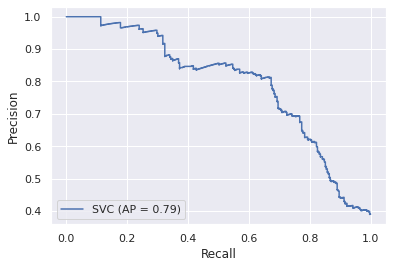

In [36]:
plot_precision_recall_curve(best_svc, strat_train_prep, strat_train_labels, response_method="decision_function")

In [37]:
pred = best_svc.predict(strat_devtest_prep)
confusion_matrix(strat_devtest_labels, pred)

array([[46, 11],
       [12, 21]])

In [45]:
# thresh = 0.65
# custom_thresh_preds = pred_scores > thresh
# precisions, recalls, thresholds = precision_recall_curve(strat_devtest_labels, custom_thresh_preds[:, 1])

# sns.lineplot(thresholds, precisions[:-1], color="r")
# sns.lineplot(thresholds, recalls[:-1], color="b")

In [40]:
confusion_matrix(strat_devtest_labels, custom_thresh_preds[:,1])

In [46]:
#best_model = RandomForestClassifier(random_state=42)
best_model = best_svc

full_train = titanic.drop("Survived", axis=1)
full_train_prep = attr_pip.fit_transform(full_train)
best_model.fit(full_train_prep, titanic_labels)

test = pd.read_csv(fname_test)
test_prep = attr_pip.fit_transform(test)
titanic_prep = attr_pip.fit_transform(titanic)

#sgd_clf.fit(titanic_prep, titanic_labels)
#survival_pred = sgd_clf.predict(test_prep)

survival_pred = best_model.predict(test_prep)


survival_proba = best_model.predict_proba(test_prep)
survival_pred = survival_proba > thresh
survival_pred = survival_pred[:, 1].astype(int)


survival_pred = pd.DataFrame(survival_pred, columns=["Survived"])

id_survival = pd.concat([test.PassengerId, survival_pred], axis=1)
id_survival.set_index("PassengerId", inplace=True)
id_survival.to_csv("predicition.csv")
id_survival

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0
